In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import find_peaks

import OrbitalMotion as om

In [3]:
# Example from Tutorial
# https://www.stjarnhimlen.se/comp/tutorial.html#5
d = om.OrbitalMotion.date(19, 4.0, 1990)
sun_arr = om.OrbitalMotion.sunPos(d)
merc_arr = om.OrbitalMotion.getPlanPos(1, d)
# Heliocentric
print(merc_arr)
merc_geo = om.OrbitalMotion.togeo(sun_arr, merc_arr)
#print(merc_geo)
mer_geo_eq = om.Coordinates.ecEq(merc_geo[0], merc_geo[1], merc_geo[2], sun_arr[11])
print(mer_geo_eq[0], mer_geo_eq[1], mer_geo_eq[2])
sphere = om.Coordinates.sphere(mer_geo_eq[0], mer_geo_eq[1], mer_geo_eq[2])
print(sphere)

(-0.3678208693993782, 0.06108452909848423, 0.03869908805497192, 170.57086510954457, 5.925527266740486, 0.37486148252012297)
0.5132266546425799 0.48296234260038473 0.25158260486587974
(43.25988423931299, 19.64595158381238, 0.7482967529508375)


In [171]:
# Azi/Alt testing
LST = om.OrbitalMotion.sidereal(0, sun_arr[9], 15)
print(LST/15)
azi = om.Coordinates.azimuthal(sphere[0], sphere[1], LST, 60)
#sphere[2]
#mpar = om.asind(1/sphere[2])
#print(azi[0], azi[1] - mpar * om.cosd(azi[1]))
print(azi)

14.7892554576
HA =  178.578947624687
(358.63956376436687, -10.345613263572636)


In [176]:
d = om.OrbitalMotion.date(19, 4.0, 1990)
sun_arr = om.OrbitalMotion.sunPos(d)
moon_arr = om.OrbitalMotion.getPlanPos(0, d)
# Geocentric Longitude and Latitude
print("Long/Lat", om.rev(moon_arr[3]), moon_arr[4], moon_arr[5])
#mag = sqrt(moon_arr[0] ** 2 + moon_arr[1] ** 2 + moon_arr[2] ** 2)
#print(moon_arr[0], moon_arr[1], moon_arr[2])

#print(moon_arr[0] / mag, moon_arr[1] / mag, moon_arr[2] / mag)
# RA and Decl
rect = om.Coordinates.rect(moon_arr[3], moon_arr[4])
#print(rect)
equat = om.Coordinates.ecEq(rect[0], rect[1], rect[2], sun_arr[11])
#print(equat)
sphere = om.Coordinates.sphere(equat[0], equat[1], equat[2])
print('RA = ', om.rev(sphere[0]), "Decl = ", sphere[1])
LST = om.OrbitalMotion.sidereal(0, sun_arr[9], 15)
#print(LST/15)
azi = om.Coordinates.azimuthal(sphere[0], sphere[1], LST, 60)
print("Azi", azi)
print(azi[1] - om.asind(1/moon_arr[5])*om.cosd(azi[1]))
print(om.Coordinates.azmuthal(310.0017, -19.8790))

Long/Lat 306.9483873098253 -0.5856163847702522 60.67790303343744
RA =  309.5011258456264 Decl =  -19.103244594505494
HA =  272.3377060183736
Azi (101.786802739008, -15.316677995212503)
-16.22744064557752


In [6]:
print(sun_arr[6], sun_arr[7])
azi = om.Coordinates.azimuthal(sun_arr[6], sun_arr[7], LST, 60)
print(azi)

26.658077679334305 11.008374735025573
HA =  195.1807541846657
(15.676697321318017, -17.957006397288975)


In [14]:
"""
    Collecting data for two planets starting at 
    date value d and continuing for const days
"""
d = 0.0
const = 365*13
# x,y,z equatorial coordinates
p1 = np.zeros((3, const))
p2 = np.zeros((3, const))
for i in range (const):
    sun_arr = om.OrbitalMotion.sunPos(d)
    p1_arr = om.OrbitalMotion.getPlanPos(1, d)
    p2_arr = om.OrbitalMotion.getPlanPos(4, d)
    
    p1_geo = om.OrbitalMotion.togeo(sun_arr, p1_arr)
    p1_geo_eq = om.Coordinates.ecEq(p1_geo[0], p1_geo[1], p1_geo[2], sun_arr[11])
    p1[0][i] = p1_geo_eq[0]
    p1[1][i] = p1_geo_eq[1]
    p1[2][i] = p1_geo_eq[2]

    p2_geo = om.OrbitalMotion.togeo(sun_arr, p2_arr)
    p2_geo_eq = om.Coordinates.ecEq(p2_geo[0], p2_geo[1], p2_geo[2], sun_arr[11])
    p2[0][i] = p2_geo_eq[0]
    p2[1][i] = p2_geo_eq[1]
    p2[2][i] = p2_geo_eq[2]
    d += 1

Text(0.5, 0, 'Location from Earth in astronomical units (x)')

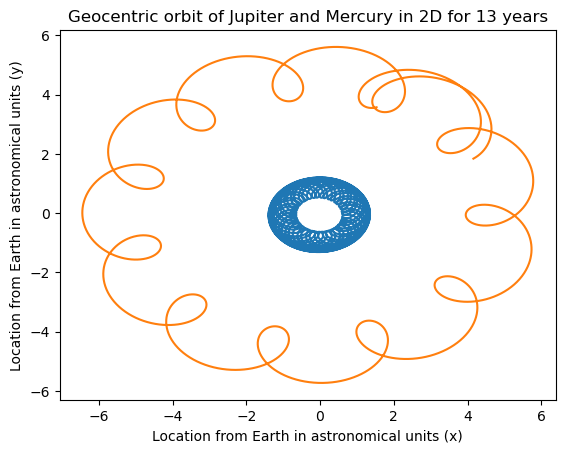

In [15]:
plt.plot(p1[0], p1[1])
plt.plot(p2[0], p2[1])
plt.title("Geocentric orbit of Jupiter and Mercury in 2D for 13 years")
plt.ylabel("Location from Earth in astronomical units (y)")
plt.xlabel("Location from Earth in astronomical units (x)")

(array([  81,  172,  262,  352,  442,  533,  623,  713,  803,  893,  983,
       1073, 1163, 1253, 1343, 1432, 1522, 1612, 1701, 1791, 1880, 1970,
       2059, 2149, 2238, 2327, 2417, 2506, 2595, 2685, 2774, 2863, 2953,
       3042, 3132, 3221, 3311, 3400, 3490, 3580, 3670, 3760, 3850, 3940,
       4030, 4121, 4211, 4301, 4391, 4482, 4572, 4662], dtype=int64), {})


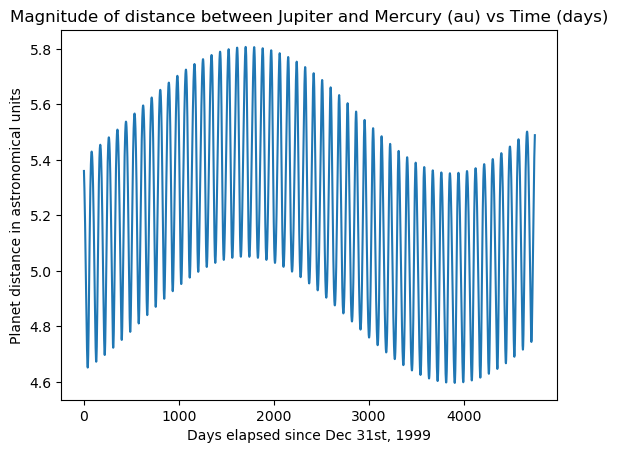

In [16]:
mag = np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2 + (p1[2] - p2[2]) ** 2 )
plt.plot(np.arange(0, const), mag)
plt.title("Magnitude of distance between Jupiter and Mercury (au) vs Time (days)")
plt.ylabel("Planet distance in astronomical units")
plt.xlabel("Days elapsed since Dec 31st, 1999")


print(find_peaks(mag))

(array([  53,  105,  107,  159,  161,  213,  215,  267,  279,  323,  375,
        379,  431, 4314, 4366, 4370, 4422, 4466, 4478, 4530, 4532, 4584,
       4586, 4638, 4640, 4692], dtype=int64), {})


Text(0.5, 0, 'Frequency')

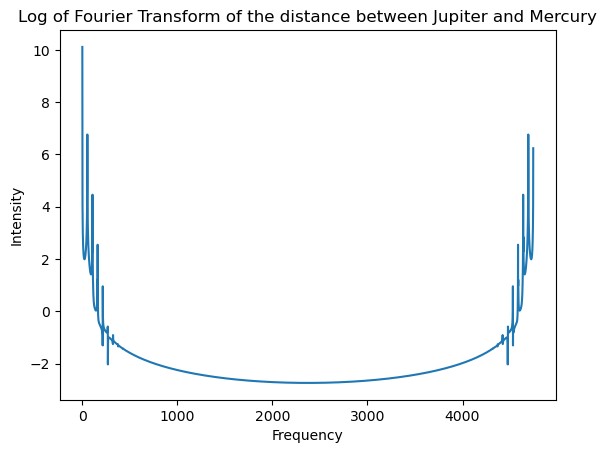

In [20]:
y = fft(mag)
z =np.log(abs(y))
plt.plot(z)
z1 = find_peaks(z)
print(z1)
plt.title("Log of Fourier Transform of the distance between Jupiter and Mercury")
plt.ylabel("Intensity")
plt.xlabel("Frequency")

In [6]:
# Temporary function for returning information pertaining to a singular planet
def temp_func(n, const):    
    d = 0.0
    # x,y,z equatorial coordinates
    p1 = np.zeros((3, const))
    sun = np.zeros((3, const))
    p1_0 = np.zeros((3, const))
    #sun_0 = np.zeros((2, const))
    for i in range (const):
        sun_arr = om.OrbitalMotion.sunPos(d)
        p1_arr = om.OrbitalMotion.getPlanPos(n, d)
        
        p1_geo = om.OrbitalMotion.togeo(sun_arr, p1_arr)
        p1_geo_eq = om.Coordinates.ecEq(p1_geo[0], p1_geo[1], p1_geo[2], sun_arr[11])

        sun[0][i] = sun_arr[3] 
        sun[0][i] = sun_arr[4]
        sun[0][i] = sun_arr[5] 

        #sun_0[0][i] = sun_arr[6]
        #sun_0[0][i] = sun_arr[7]


        p1[0][i] = p1_geo_eq[0] 
        p1[1][i] = p1_geo_eq[1] 
        p1[2][i] = p1_geo_eq[2] 

        temp = om.Coordinates.sphere(p1_geo[0], p1_geo[1], p1_geo[2])
        p1_0[0][i] = temp[0]
        p1_0[1][i] = temp[1]
        p1_0[2][i] = p1_arr[5]
        d += 1

    return p1, sun, p1_0

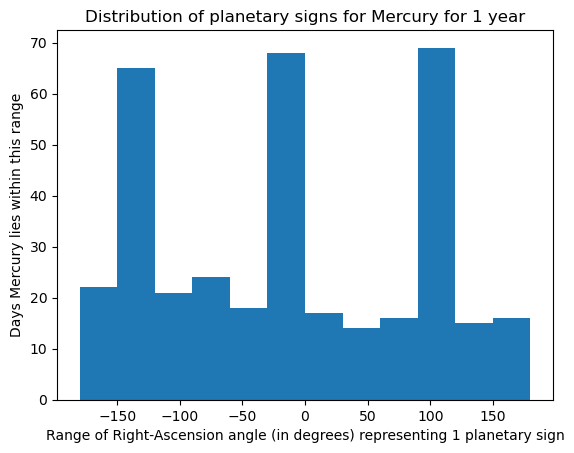

In [21]:
# Distribution of RA angles for Mercury (we hope)
const = 365*1
p1, sun, p1_0 = temp_func(1, const)

plt.hist(p1_0[0], bins = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
plt.title("Distribution of planetary signs for Mercury for 1 year")
plt.xlabel("Range of Right-Ascension angle (in degrees) representing 1 planetary sign")
plt.ylabel("Days Mercury lies within this range")
plt.show()

#print(p1_0[0])

In [13]:
p1_hist = np.histogram(p1_0[0], bins=[-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])

for i in range(len(p1_hist[0])):
    print("Days Mercury lies in the sign of range [" +  str(p1_hist[1][i]) + "," + str(p1_hist[1][i+1]) + ") degrees: ", p1_hist[0][i])
p1_hist

sum = 0
for i in range(len(p1_hist[0])):
    sum += p1_hist[0][i]

print(sum)

Days Mercury lies in the sign of range [-180,-150) degrees:  22
Days Mercury lies in the sign of range [-150,-120) degrees:  65
Days Mercury lies in the sign of range [-120,-90) degrees:  21
Days Mercury lies in the sign of range [-90,-60) degrees:  24
Days Mercury lies in the sign of range [-60,-30) degrees:  18
Days Mercury lies in the sign of range [-30,0) degrees:  68
Days Mercury lies in the sign of range [0,30) degrees:  17
Days Mercury lies in the sign of range [30,60) degrees:  14
Days Mercury lies in the sign of range [60,90) degrees:  16
Days Mercury lies in the sign of range [90,120) degrees:  69
Days Mercury lies in the sign of range [120,150) degrees:  15
Days Mercury lies in the sign of range [150,180) degrees:  16
365


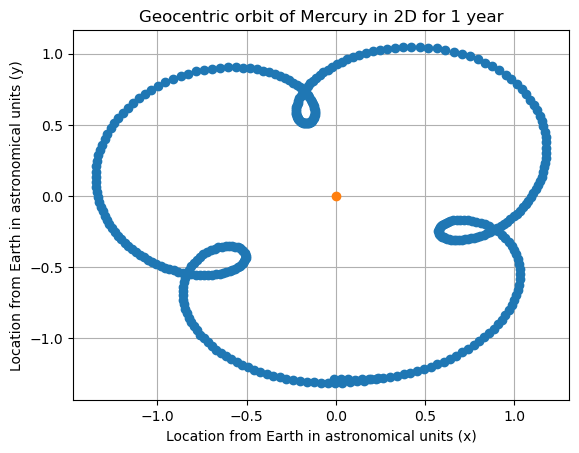

In [22]:
plt.plot(p1[0], p1[1], 'o')
plt.plot(0, 0, 'o')
plt.grid(True)
plt.title("Geocentric orbit of Mercury in 2D for 1 year")
plt.xlabel("Location from Earth in astronomical units (x)")
plt.ylabel("Location from Earth in astronomical units (y)")
plt.show()